## Research Agent

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

Tools:
- Web search (Tavily Extract)
- RAG search
- RAG search w/ filter
- Final answer formatting

Packages used:

langchain-ollama


In [2]:
from langchain_tavily import TavilyExtract

bsky_doc_urls = [
    'https://docs.bsky.app/docs/advanced-guides/atproto',
    'https://docs.bsky.app/docs/advanced-guides/federation-architecture',
    'https://docs.bsky.app/docs/advanced-guides/moderation'
]

tav_tool = TavilyExtract()

In [3]:
res = tav_tool.invoke({'urls': bsky_doc_urls})

In [4]:
res

{'results': [{'url': 'https://docs.bsky.app/docs/advanced-guides/federation-architecture',
   'raw_content': 'Federation Architecture | Bluesky\n\n===============\n\n[Skip to main content](https://docs.bsky.app/docs/advanced-guides/federation-architecture#__docusaurus_skipToContent_fallback)\n\n[![Image 1: Bluesky Logo](https://docs.bsky.app/img/favicon.png) **Bluesky**](https://docs.bsky.app/)[Docs](https://docs.bsky.app/docs/get-started)[Blog](https://docs.bsky.app/blog)[Showcase](https://docs.bsky.app/showcase)\n\n[GitHub](https://github.com/bluesky-social)\n\nSearch K\n\n*   [Get Started](https://docs.bsky.app/docs/get-started)\n*   [Tutorials](https://docs.bsky.app/docs/category/tutorials) \n*   [Starter Templates](https://docs.bsky.app/docs/category/starter-templates) \n*   [Advanced Guides](https://docs.bsky.app/docs/category/advanced-guides) \n    *   [The AT Protocol](https://docs.bsky.app/docs/advanced-guides/atproto)\n    *   [Federation Architecture](https://docs.bsky.app/d

### Graph State

In [2]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    input: str # 
    chat_history: List[BaseMessage]
    intermediate_steps: Annotated[List[tuple[AgentAction, str]], operator.add]

- `input`: the user's most recent query, i.e., the question we want to answer with the research agent.
- `chat_history`: allows previous interactions to give additional context throughout the agent logic
- `intermediate_steps`: gives a record of all the steps the research agent will take between the user asking a question via `input` and the agent giving a final answer.

### Custom tools

In [3]:
from langchain_tavily import TavilySearch

# Search tool
web_search = TavilySearch(
    max_results=5,
    topic="general",
)

In [ ]:
# ----> SKIP THIS CELL - this is for injection of args at runtime - expermiental, not used as tool below
from langchain_core.tools import InjectedToolArg, tool
from typing_extensions import Annotated

@tool('w_search')
def w_search(urls: Annotated[list[str], InjectedToolArg]):
    """Retrieve information from bluesky online documentation"""
    res = TavilyExtract().invoke(urls)
    return res

print(w_search.get_input_schema().model_json_schema())
print(w_search.tool_call_schema.model_json_schema())

In [4]:
# Retriever
from utils import load_docs, split_code, create_retriever # defined in utils.py file
from langchain_text_splitters import Language
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

from langchain_core.vectorstores import InMemoryVectorStore
from langchain_ollama import OllamaEmbeddings

SOURCE_CODE_PATH = './data/labeler-starter-kit-bsky-main/src'
FILE_EXTS = [".ts"]
LANG = Language.TS

def create_vector_store(src_path, file_extensions, lang):
    """Searches information from .ts documents stored in memory vector DB"""
    docs = load_docs(src_path, file_extensions)
    split_docs = split_code(docs, lang)
    embeddings = OllamaEmbeddings(model='llama3.2')
    
    vector_store = InMemoryVectorStore(embeddings)
    _ = vector_store.add_documents(split_docs)
    return vector_store


In [5]:
vs = create_vector_store(SOURCE_CODE_PATH, FILE_EXTS, LANG)

In [6]:
from langchain_core.tools import tool

@tool(response_format='content_and_artifact')
def retrieve(query):
    """Retrieve information related to a query"""
    retrieved_docs = vs.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [7]:
res = retrieve.invoke('shutdown()')
print(res)

Source: {'source': 'data/labeler-starter-kit-bsky-main/src/main.ts', 'language': <Language.TS: 'ts'>}
Content: function shutdown() {
  try {
    logger.info('Shutting down gracefully...');
    fs.writeFileSync('cursor.txt', jetstream.cursor!.toString(), 'utf8');
    jetstream.close();
    labelerServer.stop();
    metricsServer.close();
  } catch (error) {
    logger.error(`Error shutting down gracefully: ${error}`);
    process.exit(1);
  }
}

Source: {'source': 'data/labeler-starter-kit-bsky-main/src/main.ts', 'language': <Language.TS: 'ts'>}
Content: const metricsServer = startMetricsServer(METRICS_PORT);

labelerServer.app.listen({ port: PORT, host: HOST }, (error, address) => {
  if (error) {
    logger.error('Error starting server: %s', error);
  } else {
    logger.info(`Labeler server listening on ${address}`);
  }
});

jetstream.start();


In [8]:
@tool('final_answer')
def final_answer(research_steps, main_body, sources):
    """Returns a natural language response to the user with a specific output format"""
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ''

## Supervisor LLM

The graph's decision-maker. It has a set of potential function call (ie our tools) that it can decide to use. It will use at least one of those tools using the `tool_choice='any'` setting. The supervisor only makes the decision to use a tool, and does not execute the tool code itself.

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),
    MessagesPlaceholder(variable_name='chat_history'),
    ('user', '{input}'),
    ('assistant', 'scratchpad: {scratchpad}')
])

In [10]:
import os
from langchain_core.messages import ToolCall, ToolMessage
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

# llm = ChatOllama(model='mistral:7b')
llm = ChatOpenAI( # Performs much better but is expensive!
    model='gpt-4o',
    openai_api_key=os.environ['OPENAI_API_KEY'],
    temperature=0
)

tools = [
    web_search,
    retrieve,
    final_answer
]

# function to transform intermediate_steps from list of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != 'TBD':
            # this was the ToolExecution
            research_steps.append(
                f'Tool: {action.tool}, input: {action.input}\n'
                f'Output: {action.log}'
            )
    return '\n---\n'.join(research_steps)

oracle = (
    {
        'input': lambda x: x['input'],
        'chat_history': lambda x: x['chat_history'],
        'scratchpad': lambda x: create_scratchpad(
            intermediate_steps=x['intermediate_steps']
        )
    }
    | prompt
    | llm.bind_tools(tools, tool_choice='any')
)

In [11]:
inputs = {
    'input': 'tell me something about the bluesky app',
    'chat_history': [],
    'intermediate_steps': []
}
out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_B3aw7fXNJVRWee8w0025TXLk', 'function': {'arguments': '{"query": "Bluesky app overview", "search_depth": "advanced"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'call_9v91H4wiGwLFSP3JQtchmhSt', 'function': {'arguments': '{"query": "Bluesky app"}', 'name': 'retrieve'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 1489, 'total_tokens': 1546, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ed2df573-ce54-42c8-a498-66b41fbd56de-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Bluesky app overview', 'search_depth': 'advanced'}, 'id': 'call_B3aw7

In [12]:
out.tool_calls[0]['name']

'tavily_search'

In [13]:
out.tool_calls[0]['args']

{'query': 'Bluesky app overview', 'search_depth': 'advanced'}

In [14]:
def run_oracle(state: list):
    print('run_oracle')
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]['name']
    tool_args = out.tool_calls[0]['args']
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log='TBD'
    )
    return {
        'intermediate_steps': [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state['intermediate_steps'], list):
        return state['intermediate_steps'][-1].tool
    else:
        # if bad format is output go to final answer
        print('Router invalid format')
        return 'final_answer'

In [15]:
tool_str_to_func = {
    'tavily_search': web_search,
    'retrieve': retrieve,
    'final_answer': final_answer
}

def run_tool(state:list):
    tool_name = state['intermediate_steps'][-1].tool
    tool_args = state['intermediate_steps'][-1].tool_input
    print(f'{tool_name}.invoke(input={tool_args})')
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {
        'intermediate_steps': [action_out]
    }

### Defining graph

In [16]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node('oracle', run_oracle)
graph.add_node('tavily_search', run_tool)
graph.add_node('retrieve', run_tool)
graph.add_node('final_answer', run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source='oracle',
    path=router #function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != 'final_answer':
        graph.add_edge(tool_obj.name, 'oracle')

# if anything does to final answer, it must then move to END
graph.add_edge('final_answer', END)

runnable = graph.compile()

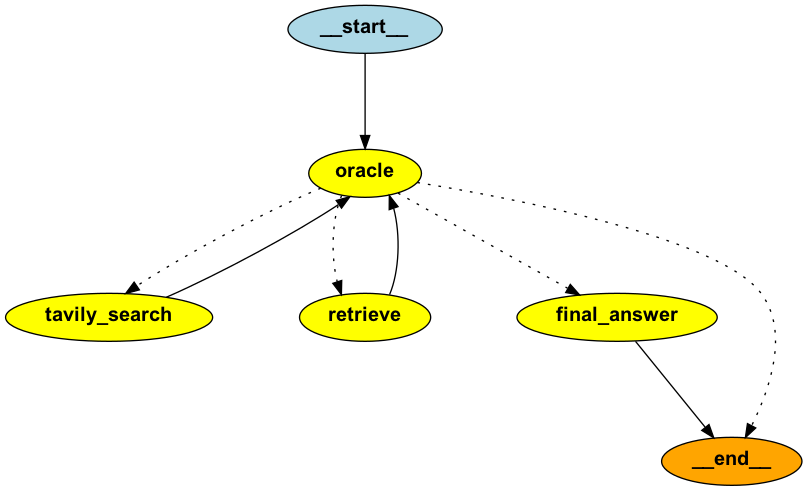

In [17]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())